In [1]:
import pandas as pd
import numpy as np
import datetime
import pickle

Notas: A nossa solução inicial assumia que era possível fazer o tracing das bicicletas, mas após ser fornecido o dicionário, percebemos que tal não era possível dado que "The same bike can have multiple tags over the year".

In [2]:
base = '/home/ana/Downloads/'

In [3]:
def get_loans_clean(base):

    df = pd.read_pickle(base + 'df_clean')[["Id_Historico_Prestamo", "Id_Usuario", "Id_Tag_Bicicleta", \
            "Fecha_Prestamo", "Fecha_Devolucion", "Id_Aparcamiento_Origen", "Posicion_Origen", \
            "Id_Aparcamiento_Destino", "Posicion_Destino"]]
    
    # Rename columns
    # The same bike can have multiple tags over the year.
    df = df.rename(columns={
        "Id_Historico_Prestamo": "Loan ID",
        "Id_Usuario": "User ID",
        "Id_Tag_Bicicleta": "Tag ID",
        "Fecha_Prestamo": "Start loan",
        "Fecha_Devolucion": "End loan",
        "Id_Aparcamiento_Origen": "ID start station",
        "Posicion_Origen": "Position start",
        "Id_Aparcamiento_Destino": "ID end station",
        "Posicion_Destino": "Position end"
    })
    
    return df

df = get_loans_clean(base)

In [4]:
df

,Loan ID,User ID,Tag ID,Start loan,End loan,ID start station,Position start,ID end station,Position end
0,6501462,18701,1164,2017-06-21 14:22:11.000,2017-06-21 14:38:29.000,8,1,43.0,1.0
1,6501318,41811,1089,2017-06-21 14:07:18.000,2017-06-21 14:39:06.000,56,6,54.0,NaN
2,6501489,96620,1110,2017-06-21 14:25:11.000,2017-06-21 14:39:07.000,36,25,9.0,13.0
3,6501001,16055,1465,2017-06-21 13:35:52.000,2017-06-21 14:39:22.000,8,1,9.0,6.0
4,6501421,6431,996,2017-06-21 14:17:56.000,2017-06-21 14:39:26.000,56,14,54.0,NaN
...,...,...,...,...,...,...,...,...,...
10387747,14454800,27944,2369,2019-12-31 13:58:55.000,2019-12-31 14:25:38.000,40,1,50.0,1.0
10387748,14454778,108800,2393,2019-12-31 13:52:48.000,2019-12-31 14:40:52.000,28,1,50.0,1.0
10387749,14454793,98449,60,2019-12-31 13:55:47.000,2019-12-31 14:41:39.000,113,1,28.0,1.0
10387750,14454774,129665,1829,2019-12-31 13:51:28.000,2019-12-31 16:27:12.000,39,15,41.0,15.0


In [5]:
# Vou apenas usar as primeiras 100k linhas
df = df.iloc[:100000,:]
df

,Loan ID,User ID,Tag ID,Start loan,End loan,ID start station,Position start,ID end station,Position end
0,6501462,18701,1164,2017-06-21 14:22:11.000,2017-06-21 14:38:29.000,8,1,43.0,1.0
1,6501318,41811,1089,2017-06-21 14:07:18.000,2017-06-21 14:39:06.000,56,6,54.0,NaN
2,6501489,96620,1110,2017-06-21 14:25:11.000,2017-06-21 14:39:07.000,36,25,9.0,13.0
3,6501001,16055,1465,2017-06-21 13:35:52.000,2017-06-21 14:39:22.000,8,1,9.0,6.0
4,6501421,6431,996,2017-06-21 14:17:56.000,2017-06-21 14:39:26.000,56,14,54.0,NaN
...,...,...,...,...,...,...,...,...,...
99995,6455073,20785,723,2017-06-14 11:05:41.000,2017-06-14 11:19:15.000,39,15,41.0,20.0
99996,6455090,24622,1289,2017-06-14 11:07:34.000,2017-06-14 11:19:18.000,21,1,42.0,37.0
99997,6455051,19113,957,2017-06-14 11:03:42.000,2017-06-14 11:19:25.000,55,1,10.0,1.0
99998,6455031,32812,1480,2017-06-14 11:00:19.000,2017-06-14 11:19:41.000,41,1,2.0,1.0


Stations information

In [6]:
df_info = pd.read_csv("station_location_with_id.csv", sep=';')[['ID','numSlots','isManual']]
df_info.head()

,ID,numSlots,isManual
0,1,15,1
1,2,33,1
2,3,40,0
3,4,10,1
4,5,33,1


Loans per minute

In [31]:
# !!!!!!!!!!!!!!!!!!!!! returns !!!!!!!!!!!!!!!!!!!!!

def get_loans_or_devolutions_per_station_per_5_minutes(_df, field_date, field_station, field_position):
    df = _df.copy()
    df = df[[field_date, field_station, field_position]]
    df[field_position] = [1]*len(df.index)
    df[field_date] = pd.to_datetime(df[field_date], format='%Y-%m-%d %H:%M:%S.%f')
    df[field_date] = df[field_date].dt.strftime('%Y-%m-%d %H:%M')
    df[field_date] = df[field_date].apply(pd.to_datetime).dt.round("5min")
    df = df.rename(columns={field_date:'Date', field_station:'Station'})
    df = df.groupby(['Station', 'Date']).count()
    
    if(field_date=='Start loan'):
        df = df.rename(columns={field_position:'N Loans'})
    else:
        df = df.rename(columns={field_position:'N Devolutions'})
        
    return df

def get_loans_and_devolutions_info(_df):
    loans = get_loans_or_devolutions_per_station_per_5_minutes(_df, \
                    'Start loan', 'ID start station', 'Position start')
    
    devolutions = get_loans_or_devolutions_per_station_per_5_minutes(_df, \
                    'End loan', 'ID end station', 'Position end')
    
    df = pd.concat([loans, devolutions], axis=1)
    df = df.fillna(0)
    
    # FALTA FAZER POR ESTAÇÃO!!!!!!! ESTÁ GLOBAL
    df['N Loans cumsum'] = df['N Loans'].cumsum() # perdem bicicletas
    df['N Devolutions cumsum'] = df['N Devolutions'].cumsum() # ganham bicicletas
    
    df['Balance'] = df['N Devolutions cumsum'] - df['N Loans cumsum'] # balanço total
    
    
    
    
    return df

loans_and_devolutions = get_loans_and_devolutions_info(df)
loans_and_devolutions.head(5)

                             N Loans
Station Date                        
1       2016-10-14 09:55:00        1
        2016-10-14 10:00:00        1
        2016-10-14 10:05:00        1
        2016-10-14 10:25:00        1
        2016-10-14 10:40:00        1
...                              ...
70      2017-06-21 17:00:00        2
        2017-06-21 17:10:00        1
        2017-06-21 17:15:00        2
        2017-06-21 17:25:00        2
        2017-06-21 17:30:00        1

[56656 rows x 1 columns]


N Loans  N Devolutions  N Loans cumsum  \
Station Date                                                          
1.0     2016-10-14 09:55:00      1.0            0.0             1.0   
        2016-10-14 10:00:00      1.0            0.0             2.0   
        2016-10-14 10:05:00      1.0            0.0             3.0   
        2016-10-14 10:25:00      1.0            0.0             4.0   
        2016-10-14 10:40:00      1.0            0.0             5.0   

                             N Devolutions cumsum  Balance  
Station Date                                                
1.0     2016-10-14 09:55:00                   0.0     -1.0  
        2016-10-14 10:00:00                   0.0     -2.0  
        2016-10-14 10:05:00                   0.0     -3.0  
        2016-10-14 10:25:00                   0.0     -4.0  
        2016-10-14 10:40:00                   0.0     -5.0

In [22]:
loans_and_devolutions.head(10)

N Loans  N Devolutions  N Loans cumsum  \
Station Date                                                          
1.0     2016-10-14 09:55:00      1.0            0.0             1.0   
        2016-10-14 10:00:00      1.0            0.0             2.0   
        2016-10-14 10:05:00      1.0            0.0             3.0   
        2016-10-14 10:25:00      1.0            0.0             4.0   
        2016-10-14 10:40:00      1.0            0.0             5.0   
        2016-10-14 10:50:00      0.0            1.0             5.0   
        2016-10-14 10:55:00      1.0            0.0             6.0   
        2016-10-14 11:10:00      1.0            1.0             7.0   
        2016-10-14 11:15:00      1.0            0.0             8.0   
        2016-10-14 11:20:00      1.0            1.0             9.0   

                             N Devolutions cumsum  Balance  
Station Date                                                
1.0     2016-10-14 09:55:00                   0.0     -1.0  
        2016-10-14 10:00:00                   0.0     -2.0  
        2016-10-14 10:05:00                   0.0     -3.0  
        2016-10-14 10:25:00                   0.0     -4.0  
        2016-10-14 10:40:00                   0.0     -5.0  
        2016-10-14 10:50:00                   1.0     -4.0  
        2016-10-14 10:55:00                   1.0     -5.0  
        2016-10-14 11:10:00                   2.0     -5.0  
        2016-10-14 11:15:00                   2.0     -6.0  
        2016-10-14 11:20:00                   3.0     -6.0

In [24]:
loans_and_devolutions.tail(50)

N Loans  N Devolutions  N Loans cumsum  \
Station Date                                                          
70.0    2017-06-14 14:20:00      1.0            0.0         99950.0   
        2017-06-14 14:35:00      2.0            2.0         99952.0   
        2017-06-14 14:40:00      1.0            0.0         99953.0   
        2017-06-14 14:55:00      0.0            1.0         99953.0   
        2017-06-14 15:00:00      0.0            1.0         99953.0   
        2017-06-14 15:05:00      0.0            1.0         99953.0   
        2017-06-16 05:20:00      0.0            1.0         99953.0   
        2017-06-16 06:20:00      0.0            1.0         99953.0   
        2017-06-16 07:35:00      0.0            1.0         99953.0   
        2017-06-20 12:20:00      1.0            0.0         99954.0   
        2017-06-20 12:40:00      1.0            0.0         99955.0   
        2017-06-20 13:10:00      0.0            1.0         99955.0   
        2017-06-20 13:15:00      0.0            1.0         99955.0   
        2017-06-20 13:25:00      1.0            1.0         99956.0   
        2017-06-21 11:30:00      1.0            0.0         99957.0   
        2017-06-21 11:55:00      0.0            1.0         99957.0   
        2017-06-21 12:05:00      0.0            1.0         99957.0   
        2017-06-21 13:10:00      1.0            0.0         99958.0   
        2017-06-21 13:25:00      1.0            0.0         99959.0   
        2017-06-21 13:40:00      1.0            0.0         99960.0   
        2017-06-21 14:00:00      1.0            0.0         99961.0   
        2017-06-21 14:35:00      1.0            0.0         99962.0   
        2017-06-21 14:40:00      1.0            0.0         99963.0   
        2017-06-21 14:45:00      2.0            1.0         99965.0   
        2017-06-21 14:50:00      0.0            1.0         99965.0   
        2017-06-21 14:55:00      2.0            0.0         99967.0   
        2017-06-21 15:05:00      2.0            1.0         99969.0   
        2017-06-21 15:10:00      2.0            1.0         99971.0   
        2017-06-21 15:15:00      0.0            2.0         99971.0   
        2017-06-21 15:20:00      4.0            0.0         99975.0   
        2017-06-21 15:25:00      1.0            0.0         99976.0   
        2017-06-21 15:30:00      1.0            2.0         99977.0   
        2017-06-21 15:35:00      2.0            2.0         99979.0   
        2017-06-21 15:40:00      1.0            1.0         99980.0   
        2017-06-21 15:45:00      2.0            1.0         99982.0   
        2017-06-21 15:50:00      1.0            0.0         99983.0   
        2017-06-21 15:55:00      3.0            0.0         99986.0   
        2017-06-21 16:00:00      2.0            0.0         99988.0   
        2017-06-21 16:05:00      1.0            1.0         99989.0   
        2017-06-21 16:20:00      1.0            1.0         99990.0   
        2017-06-21 16:30:00      0.0            2.0         99990.0   
        2017-06-21 16:35:00      1.0            0.0         99991.0   
        2017-06-21 16:40:00      1.0            1.0         99992.0   
        2017-06-21 16:50:00      0.0            1.0         99992.0   
        2017-06-21 17:00:00      2.0            1.0         99994.0   
        2017-06-21 17:10:00      1.0            0.0         99995.0   
        2017-06-21 17:15:00      2.0            0.0         99997.0   
        2017-06-21 17:25:00      2.0            0.0         99999.0   
        2017-06-21 17:30:00      1.0            0.0        100000.0   
79.0    2017-06-08 22:15:00      0.0            1.0        100000.0   

                             N Devolutions cumsum  Balance  
Station Date                                                
70.0    2017-06-14 14:20:00               99967.0     17.0  
        2017-06-14 14:35:00               99969.0     17.0  
        2017-06-14 14:40:00               99969.0     16.0  
        2017-06-14 14:55:00    

<AxesSubplot:>

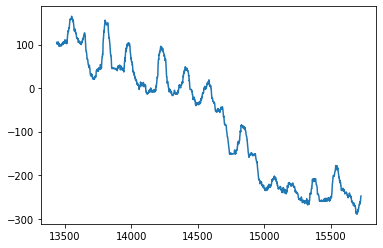

In [30]:
def plot_balance(loans_and_devolutions):
    balance_df = loans_and_devolutions.copy()
    balance_df = balance_df.reset_index()
    balance_df = balance_df.loc[balance_df["Station"]==8]
    balance_df = balance_df[["Date", "Balance"]]
    balance_df['Balance'].plot()
    
    ## corrigir - timesteps em falta

Obter o número inicial de bicicletas por estação

In [18]:
# ver o primeiro mês em que a estação abre, e fazer a contagens por aí

def get_init_number_of_bikes_per_station(_df):
    df = _df.copy()
    df = df[["Tag ID", "Start loan", "ID start station"]]
    df["Start loan"] = pd.to_datetime(df["Start loan"], format='%Y-%m-%d %H:%M:%S.%f')
    df = df.sort_values(by="Start loan")
    # for each tag get first station
    df = df.groupby("Tag ID").first() \
            .reset_index() \
            [["Tag ID", "ID start station"]]
    # for each station get initial number of bikes 
    df = df.groupby("ID start station").count()
    return df
    
init_n_bikes = get_init_number_of_bikes_per_station(df)
init_n_bikes.tail()

,Tag ID
ID start station,
65,12
66,32
67,19
69,6
70,7


In [ ]:
# 1º PASSO deteto qnd a estação abre pela 1ª vez e obtenho o 1º mês da estação
# 2º PASSO vou ver se as bicicletas que são emprestadas pela primeira vez, se ninguém as devolveu
# 

Loans per station per minute

Verificar quando as estações automáticas cheias. -> ver para cada estação qual o nº máximo de posições diferentes e depois tentar perceber qnd é que elas estão cheias (elas estão cheias se num dado intervalo de tempo todas as positions estão ocupadas) ---> taxa de ocupação

Há posições que nunca são ocupadas!!!!

In [ ]:
def occupation_tax(nPos, maxPos):
    return (nPos*100)/maxPos

In [ ]:
# obter  a posição inicial da bicicleta de forma a saber quantas bicicletas tem cada estação inicialmente
'''
def get_bike_first_location(_df, station):

    df = _df.copy()
    df = df[['Id_Tag_Bicicleta', 'Fecha_Prestamo', 'Fecha_Devolucion', 'Id_Aparcamiento_Origen', \
             'Posicion_Origen', 'Id_Aparcamiento_Destino', 'Posicion_Destino']]
    
    df = df[(df['Id_Aparcamiento_Origen']==station) | (df['Id_Aparcamiento_Destino']==station)]
    #df_ts = df_ts.set_index(['Fecha_Prestamo', 'month'])

    return df

# eles podem ter bicicletas na estação q nós não sabemos porque nunca são emprestadas!!!!!!!!!!!!!!!!!!!!!!!!!
get_bikes_per_station(df, 8)
'''


In [ ]:
df.columns

Ver a taxa de ocupação a cada hora

Ver a capacidade de armazenamento das estações automáticas. Quais são as estações automáticas com maior capacidade de armazenamento? Quais as com menor?